# Analysis of Hate Groups and Hate Crimes Data
First, we study the SLP data of Hate groups particularly focusing on **Anti-immigrant groups**. In the last four years, we have seen an increase in the number of hate groups. Particularly, a significant raise in Anti-Immigrant groups is observed, however, it is worth noting that Anti-Immigrant groups are not as predominantly as White Nationalist or Black-separatist groups, in fact, Anti-Immigrant groups in 2019 represented only 2% of the total hate groups in the US. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

In [2]:
hg = pd.read_csv('data/splc-hate-groups.csv')
hg.head(10)

,Title,City,State,Group,Ideology,Headquarters,Statewide,Year
0,American Border Patrol,Sierra Vista,Arizona,American Border Patrol/American Patrol,Anti-Immigrant,Yes,NaN,2019
1,American Immigration Control Foundation/Americ...,Monterey,Virginia,NaN,Anti-Immigrant,Yes,NaN,2019
2,Americans for Legal Immigration (ALIPAC),Raleigh,North Carolina,NaN,Anti-Immigrant,Yes,NaN,2019
3,AZ Patriots,NaN,Arizona,NaN,Anti-Immigrant,Yes,Yes,2019
4,Californians for Population Stabilization,Ventura,California,NaN,Anti-Immigrant,NaN,NaN,2019
5,Center for Immigration Studies,Washington,District of Columbia,Center for Immigration Studies,Anti-Immigrant,Yes,NaN,2019
6,Colorado Alliance for Immigration Reform,Lakewood,Colorado,NaN,Anti-Immigrant,Yes,NaN,2019
7,Federation for American Immigration Reform,Washington,District of Columbia,Federation for American Immigration Reform,Anti-Immigrant,Yes,NaN,2019
8,Floridians for Immigration Enforcement,Pompano Beach,Florida,NaN,Anti-Immigrant,NaN,NaN,2019
9,Help Save Maryland,Monkton,Maryland,NaN,Anti-Immigrant,Yes,NaN,2019


In [56]:
pp = hg[(hg.Ideology == 'Anti-Immigrant') & (hg.Year == 2019)].shape[0]/hg[hg.Year == 2019].shape[0] *100
print('In 2019, Anti-Immigrant groups represented {}% of the total number of hate groups'.format(round(pp,2)))

In 2019, Anti-Immigrant groups represented 2.13% of the total number of hate groups


## 1. Looking at Hate Groups Over Time

In [57]:
counts = hg.groupby(['Year', 'Ideology']).size().reset_index(name='count')
top3 = counts.sort_values(by=['Year','count'], ascending=[True, False]).groupby('Year').head(3)

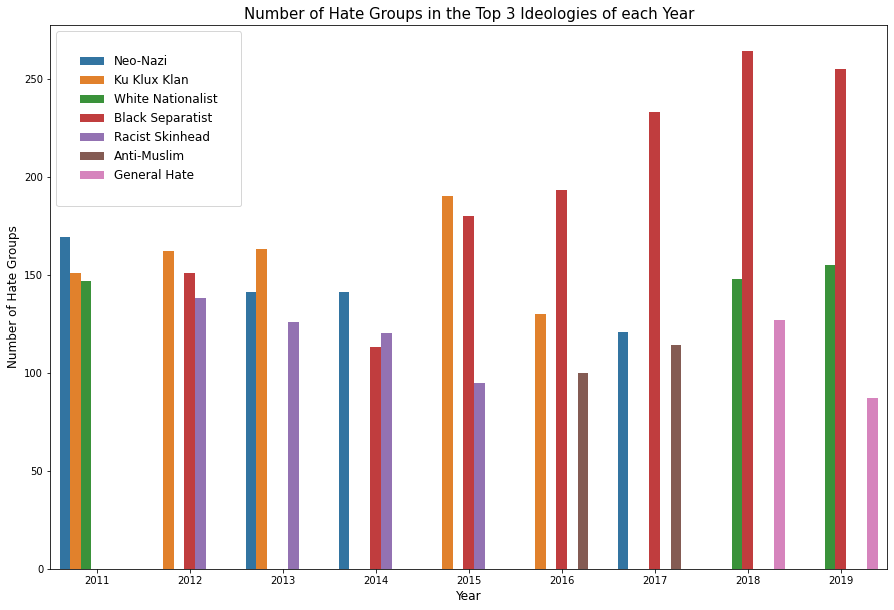

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x="Year", y="count", hue='Ideology', data=top3[top3.Year > 2010])
ax.legend(loc='upper left', borderpad=2, prop={'size':12})
plt.title('Number of Hate Groups in the Top 3 Ideologies of each Year', size=15)
plt.ylabel('Number of Hate Groups', size=12)
plt.xlabel('Year', size=12)
plt.show()

### 1.1 Hate Groups in State level

In [9]:
#Obtain geometries of US States
us = gpd.read_file('data/shapes/tl_2017_us_state.shp')
us = us[['STUSPS', 'GEOID', 'NAME', 'REGION', 'geometry']]
non_states = ['Commonwealth of the Northern Mariana Islands', 'Guam','Puerto Rico', 
              'American Samoa', 'United States Virgin Islands']
us = us.drop(us[us.apply(lambda x: True if x['NAME'] in non_states else False, axis=1)].index)
us.set_index('GEOID', inplace=True)
#Obtain population estimates
pop = pd.read_csv('data/population.csv')

In [60]:
#Merge with the counts of 2019, US Shapes and population
counts= hg.groupby(['State', 'Year']).size().reset_index(name='count')
counts_g = us[['NAME', 'geometry']].merge(counts[counts.Year == 2019], 
                                              right_on='State', left_on='NAME', 
                                              how='left').fillna({'count':0, 'Year':2019,
                                                                  'Ideology':'Anti-Immigrant'})
counts_g['State'] = counts_g['NAME']
counts_g.drop(columns=['NAME'], inplace=True)
counts_g = counts_g.merge(pop[pop.Year==2019][['State', 'population']], on=['State'])
counts_g['count_norm']= counts_g['count']*1000000/counts_g['population']

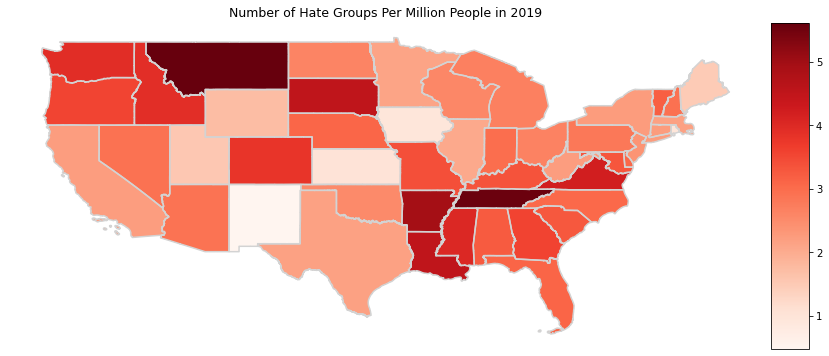

In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
c_lim = counts_g[counts_g.apply(lambda x: True if x['State']
                        not in ['District of Columbia','Alaska', 'Hawaii'] else False, axis=1)]
fig, ax = plt.subplots(figsize=(15,6))
plt.title('Number of Hate Groups Per Million People in 2019', size=12.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
c_lim.plot(column='count_norm',cmap='Reds',legend=True,ax=ax, cax=cax)
c_lim.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

### 1.2 Anti-Immigrant Groups

In [5]:
counts_im = counts[counts.Ideology == 'Anti-Immigrant']

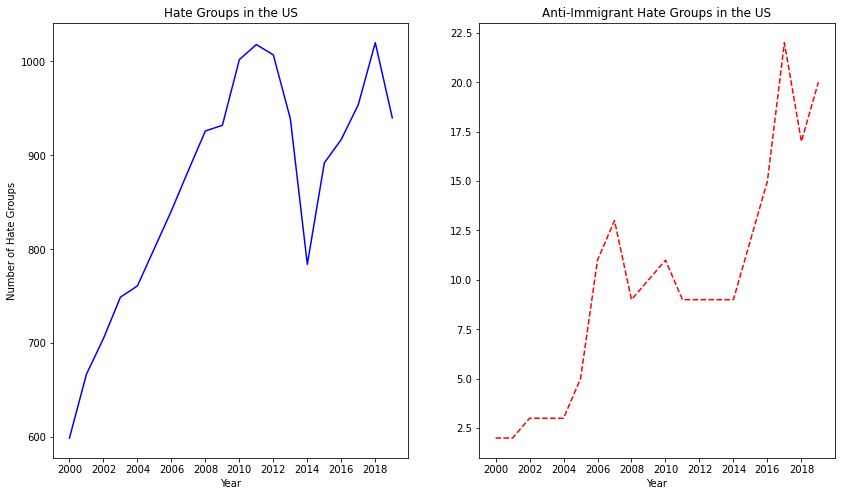

In [6]:
fig, ax = plt.subplots(figsize=(14,8), ncols=2, nrows=1)
ax1 = sns.lineplot(x="Year", y="count", 
                   data=counts.groupby('Year').agg({'count':'sum'}).reset_index(), 
                  color='blue', ax=ax[0])
freq = int(2)
ax1.set_xticks(counts.groupby('Year').agg({'count':'sum'}).reset_index().Year[::freq])
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Hate Groups')
ax1.title.set_text('Hate Groups in the US')


ax2 = sns.lineplot(x="Year", y="count", data=counts_im, color='red', ax=ax[1])
ax2.set_xticks(counts_im.Year[::freq])
ax2.lines[0].set_linestyle("--")
ax2.set_xlabel('Year')
ax2.set_ylabel('')
ax2.title.set_text('Anti-Immigrant Hate Groups in the US')

plt.show()

In [10]:
#Create a df at state, year and ideology levels. 
counts = hg.groupby(['State', 'Year', 'Ideology']).size().reset_index(name='count')

In [37]:
#Merge with the counts of 2019 and Anti-Immigrant groups
counts_g = us[['NAME', 'geometry']].merge(counts[(counts.Year == 2019) & 
                                                     (counts.Ideology == 'Anti-Immigrant')], 
                                              right_on='State', left_on='NAME', 
                                              how='left').fillna({'count':0, 'Year':2019,
                                                                  'Ideology':'Anti-Immigrant'})
counts_g['State'] = counts_g['NAME']
counts_g.drop(columns=['NAME'], inplace=True)

In [38]:
#Normalize the size of anti-immigrant groups per population
counts_g = counts_g.merge(pop[pop.Year==2019][['State', 'population']], on=['State'])
counts_g['count_norm']= counts_g['count']*1000000/counts_g['population']

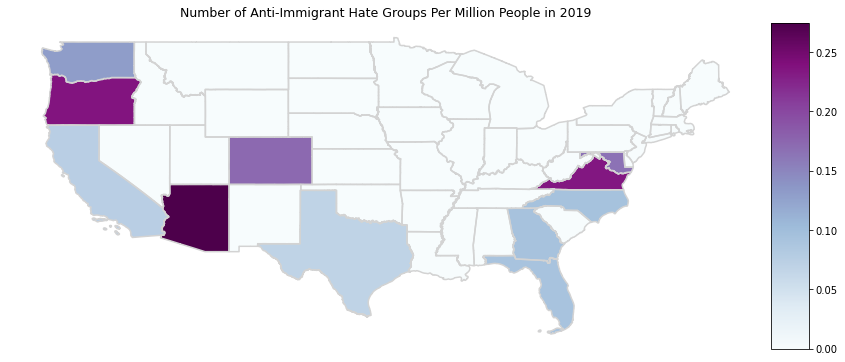

In [43]:
c_lim = counts_g[counts_g.apply(lambda x: True if x['State']
                        not in ['District of Columbia','Alaska', 'Hawaii'] else False, axis=1)]
fig, ax = plt.subplots(figsize=(15,6))
plt.title('Number of Anti-Immigrant Hate Groups Per Million People in 2019', size=12.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
c_lim.plot(column='count_norm',cmap='BuPu',legend=True,ax=ax, cax=cax)
c_lim.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

## 2. Hate crimes in the US 

In [182]:
#Get FBI data on hate crimes, limit to Single bias crimes only
hc = pd.read_csv('data/ucr_hatecrimes.csv', sep=',', dtype='unicode')
hc = hc[hc.MULTIPLE_BIAS == 'S']
hc['DATA_YEAR'] = hc['DATA_YEAR'].astype(int)

In [192]:
import re
import numpy as np
def reduce_category(word):
    '''
    Find just one category of the incident
    '''
    w = word.lower()
    w = re.sub('[^A-Za-z0-9]+', ' ', w)
    immigrant = ['asian', 'latino', 'hispanic', 'arab']
    lgbt = ['gay', 'lesbian', 'bisexual', 'transgender', 'gender']
    gender = ['female', 'male']
    race = ['black', 'white', 'race', 'native']
    religious = ['jewish', 'protestant', 'religion','muslim', 'islam','catholic',
                'atheism', 'jenovah', 'mormon', 'buddhist', 'sikh', 'christian', 'hindu', 'orthodox']
    for i in immigrant:
        if i in w:
            return 'i_{}'.format(i)
    for i in lgbt:
        if i in w:
            return 'lgbt'
    for i in gender:
        if i in w:
            return 'gender'
    for i in race:
        if i in w:
            return 'race'
    for i in religious:
        if i in w:
            return 'r_{}'.format(i)
    
    return 'other'

In [193]:
hc['cat'] = hc.apply(lambda row: reduce_category(row['BIAS_DESC']), axis=1)
hc['immigrant'] = np.where(hc.cat.str.startswith('i_'),hc.cat.str.replace('i_',''), np.nan)
hc['cat'] = np.where(hc.cat.str.startswith('i_'),'immigrant',hc.cat)
hc['religious'] = np.where(hc.cat.str.startswith('r_'),hc.cat.str.replace('r_',''), np.nan)
hc['cat'] = np.where(hc.cat.str.startswith('r_'),'religious',hc.cat)

In [194]:
counts = hc.groupby(['DATA_YEAR', 'cat']).size().reset_index(name='count')

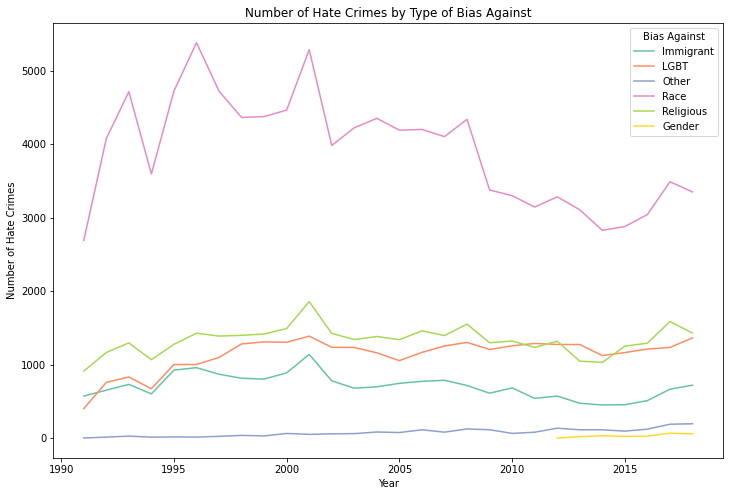

In [195]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="DATA_YEAR", y="count", hue='cat', data=counts, ax=ax, palette='Set2')
ax.legend(labels=['Immigrant','LGBT', 'Other', 'Race', 'Religious', 'Gender'], title='Bias Against')
plt.xlabel('Year')
plt.ylabel('Number of Hate Crimes')
plt.title('Number of Hate Crimes by Type of Bias Against')
plt.show()

As shown in the graph, since 1990, anti-race bias has been the leading motivation for hate crimes. 

### 2.1 Hate Crimes Against Latinos, Asians, and Arabs.

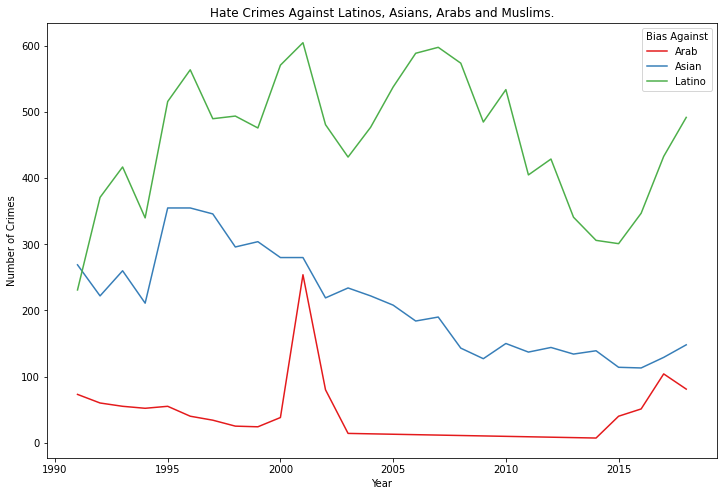

In [255]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="DATA_YEAR", y="count", hue='immigrant', 
             data=hc.groupby(['DATA_YEAR', 'immigrant']).size().reset_index(name='count'), 
             ax=ax, palette='Set1')
ax.legend(labels=['Arab', 'Asian', 'Latino'], title='Bias Against')
plt.title('Hate Crimes Against Latinos, Asians, and Arabs.')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.show()

#### State level perspective

In [282]:
#Merge population with State polygons
us_p = us.merge(pop, right_on='State', left_on='NAME')
us_p.drop(columns=['NAME', 'REGION'], inplace=True)
us_p.head(10)

,STUSPS,geometry,State,Year,population
0,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2010,1854239
1,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2011,1856301
2,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2012,1856872
3,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2013,1853914
4,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2014,1849489
5,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2015,1842050
6,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2016,1831023
7,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2017,1817004
8,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2018,1804291
9,WV,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",West Virginia,2019,1792147


In [286]:
#Get number of hate crimes to hispanic/latino
hc_latino = hc[(hc.DATA_YEAR > 2009) & 
               (hc.immigrant == 'latino')].groupby(['STATE_NAME', 
                                                    'DATA_YEAR', 
                                                    'immigrant']).size().reset_index(name='count')
hc_latino.drop(columns=['immigrant'], inplace=True)
hc_latino = us_p.merge(hc_latino, left_on=['State', 'Year'], right_on=['STATE_NAME','DATA_YEAR'], how='left')
hc_latino.drop(columns=['STATE_NAME', 'DATA_YEAR'], inplace=True)
hc_latino['count_n'] = hc_latino['count']*1000000/hc_latino['population']

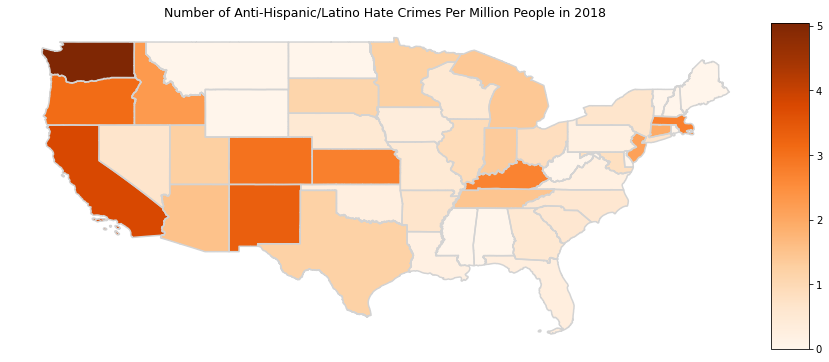

In [300]:
lat_map = hc_latino[hc_latino.apply(lambda x: True if x['State']
                        not in ['District of Columbia','Alaska', 'Hawaii'] else False, axis=1)]
lat_map = lat_map[lat_map.Year == 2018]
lat_map.fillna({'count_n':0}, inplace=True)
fig, ax = plt.subplots(figsize=(15,6))
plt.title('Number of Anti-Hispanic/Latino Hate Crimes Per Million People in 2018', size=12.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
lat_map.plot(column='count_n',cmap='Oranges',legend=True,ax=ax, cax=cax)
lat_map.boundary.plot(color='lightgrey',ax =ax)
ax.axis('off')
plt.show()

### 2.2 Hate Crimes against Jews and Muslims

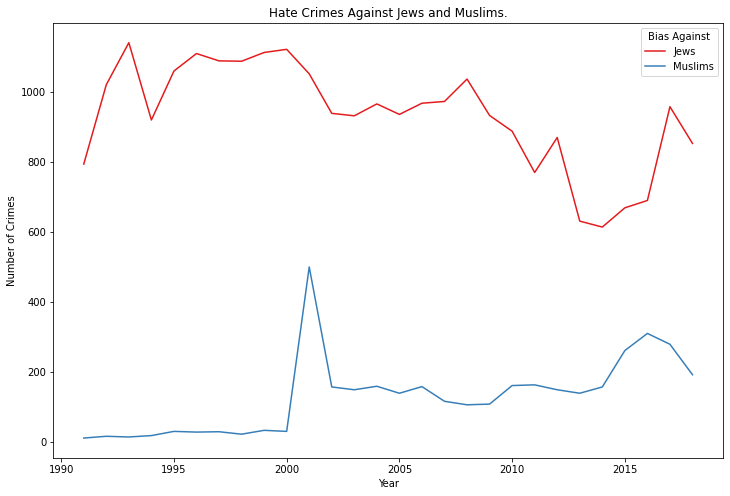

In [260]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x="DATA_YEAR", y="count", hue='religious', 
             data=hc[(hc.religious == 'jewish') | 
                     (hc.religious == 'muslim')].groupby(['DATA_YEAR', 
                                                          'religious']).size().reset_index(name='count'), 
             ax=ax, palette='Set1')
ax.legend(labels=['Jews', 'Muslims'], title='Bias Against')
plt.title('Hate Crimes Against Jews and Muslims.')
plt.ylabel('Number of Crimes')
plt.xlabel('Year')
plt.show()